<a href="https://colab.research.google.com/github/ayberkdt/Ayberk-MPA-MLF/blob/main/Fifth_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ayberk Demirkanat**

# MPA-MLF, Lab 6 - Feedforward Neural Networks with regularization techniques and hyperparameter tunning

## Exercise 1 - Classification of an images

The goal of this task will be to create Multi-layer perceptron model, that is able to recognize the  CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). The CIFAR10 dataset consist of 60000 images with resolution of 32x32 pixels. There are 10 classes in total - *airplane*, *automobile*, *bird*, *cat*, *deer*, *dog*, *frog*, *horse*, *ship*, *truck*

These is an example of the dataset:

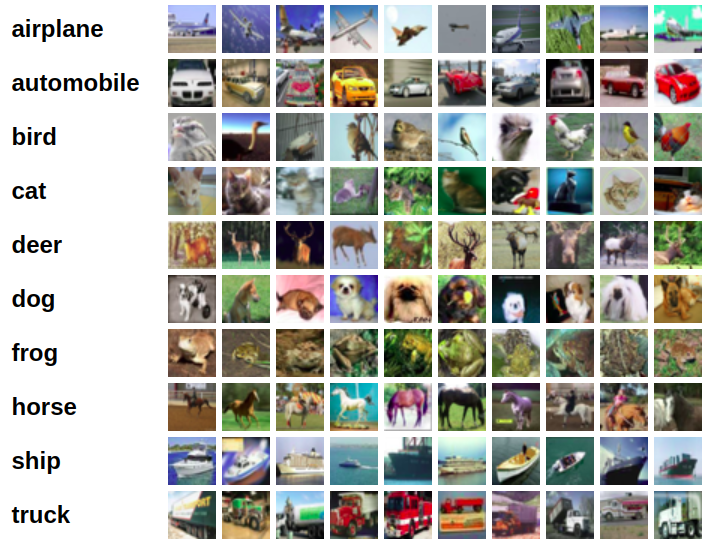

### 0. Import libraries

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

### 1. Load the Dataset
The dataset is already a part of the Keras library, so we can quickly load it using the following command

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


The following numbered labels represent the labels in the dataset:

In [ ]:
labels = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

### 2. Data Examination

Firstly, lets have a look and the couple of images we have,

In [ ]:
def display_random_images(x_data: np.array, y_data: np.array, count: int = 10) -> None:
  index = np.array(len(x_data))
  selected_ind = np.random.choice(index, count)

  selected_img = x_data[selected_ind]
  selected_labels_encoded = y_data[selected_ind]
  selected_labels = [labels[x[0]] for x in selected_labels_encoded]

  concat_img = np.concatenate(selected_img, axis=1)

  plt.figure(figsize=(20,10))
  plt.imshow(concat_img)

  for id_label, label in enumerate(selected_labels):
    plt.text((32/2) + 32*id_label - len(label), 32*(5/4), label)
  plt.axis('off')
  plt.show()



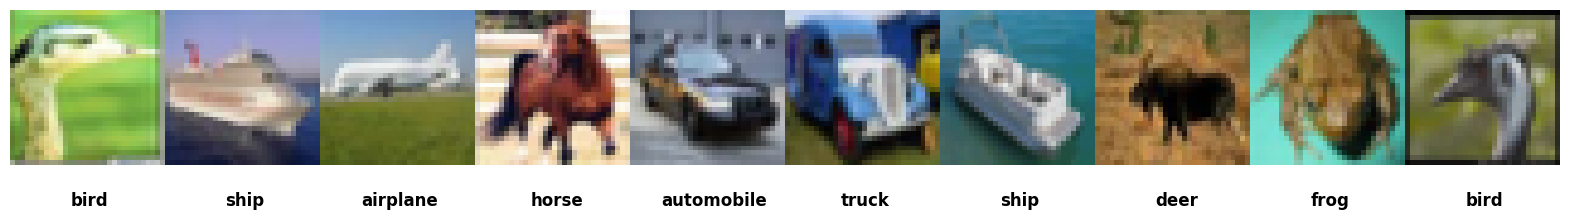

In [ ]:
display_random_images(X_train, y_train)

In [ ]:
#check the shape of image dataset

X_train.shape

(50000, 32, 32, 3)

In our dataset, we have 60000 images with 32x32 resolution. Each image has three channels (R, G, B). We have 50000 images for training and 10000 images for testing. Each channel for each image has values from 0 - 255, where each number represents the pixel intensity.
With the combination of intensities of R, G and B, you can display up to 16,777,216 different colours (256^3)

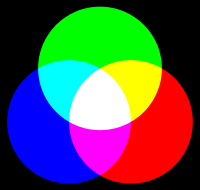

Here you can display each channel separately:

In [ ]:
def display_channels_separately(image: np.array) -> None:

  plt.figure()
  fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))


  axs[0].imshow(image[:,:,0],cmap='Reds')
  axs[1].imshow(image[:,:,1],cmap='Blues')
  axs[2].imshow(image[:,:,2],cmap='Greens')

  axs[3].imshow(image)

  plt.show()

<Figure size 640x480 with 0 Axes>

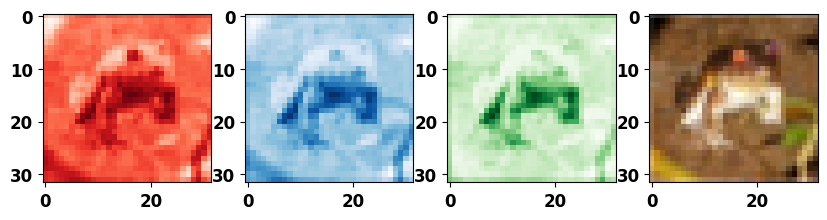

In [ ]:
display_channels_separately(X_train[0])

### 3. Preprocessing of the images

For machine learning purposes, we have to preprocess our images. Firstly we need to scale our images, to scale intensity values from 0-1 (min-max scaling)

In [ ]:
X_train_scaled = X_train.astype('float32') / 255.0


We need to one-hot-encode the labels in our ground truth variable as our second preprocessing.

In [ ]:
y_train_encoded = to_categorical(y_train, num_classes=10)

print(f"Y_train_encoded [0]: {y_train_encoded[0]}")
print(f"Y_train_encoded [10]: {y_train_encoded[10]}")

Y_train_encoded [0]: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Y_train_encoded [10]: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


## 4. Define the model architecture

-------------------------------------------------------------------------------------------------------------------------------------


### **Main Model**

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32, 3))) # Convert to one dimension
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


We will define *the Sequential* model as in our last exercise. This time we will use a different approach to determine the input layers. Instead of specifying the *input_dim* parameter in our first hidden layer, we will create a **Flatten** layer that takes our 32x32x3 image and reshapes it into 1x3072.

We will specify ten neurons in our output layer because we have 10 possible outputs and a **softmax** activation function that returns us a probability distribution over the classes. The class with the highest probability is typically chosen as the predicted class for a given input.

Check the description of our model:

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 394,634 (1.51 MB)

 Trainable params: 394,634 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

The next step is to compile our model, we will use *categorical_crossentropy* as a loss function, *stochastic gradient descend* as an optimisation and we will be checking *the accuracy* metric.

In [ ]:
optimizer = SGD(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## 5. Train the model

Our model will be trained in the same way as in our last pc_labs,

In [ ]:
history = model.fit(X_train_scaled, y_train_encoded, epochs=20, batch_size=128, validation_split = 0.2)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3294 - loss: 1.9608 - val_accuracy: 0.3268 - val_loss: 1.9621
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3322 - loss: 1.9532 - val_accuracy: 0.3274 - val_loss: 1.9586
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.3326 - loss: 1.9495 - val_accuracy: 0.3286 - val_loss: 1.9552
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3315 - loss: 1.9532 - val_accuracy: 0.3282 - val_loss: 1.9518
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3368 - loss: 1.9463 - val_accuracy: 0.3305 - val_loss: 1.9488
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.3376 - loss: 1.9408 - val_accuracy: 0.3327 - val_loss: 1.9459
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3410 - loss: 1.9345 - val_accuracy: 0.3293 - val_loss: 1.9425
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3389 - loss: 1.9326 - val_accuracy

## 6. Model evaluation

In [ ]:
X_test = X_test.astype('float32') / 255.0
y_test_encoded = to_categorical(y_test, num_classes=10)

In [ ]:
score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

Test loss: 1.9046921730041504
Test accuracy: 34.56000089645386 %


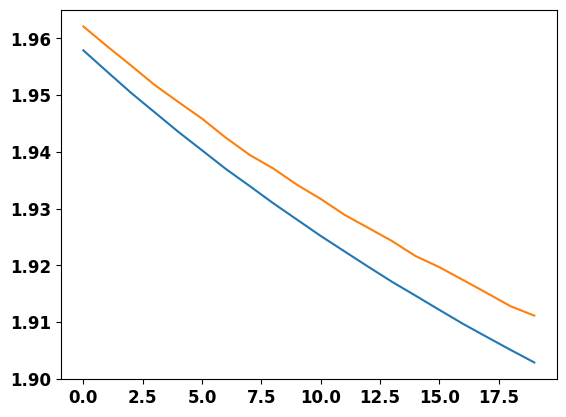

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

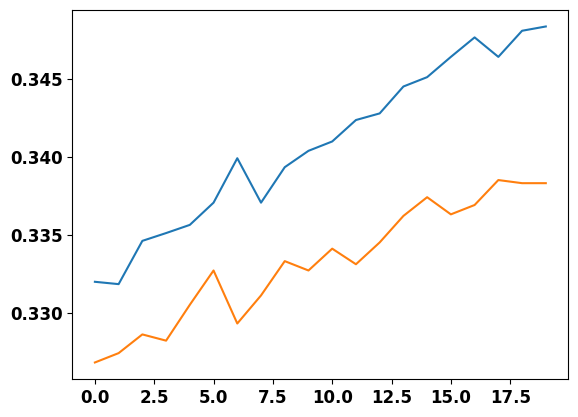

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

As you can see from the evaluation above, we was able to achive approx. 30% of an accuracy. In other word approx. 70% of an images we classified wrongly. That is really bad!

Lets check the best predictions from our model:

In [ ]:
def show_the_best_predictions(model, x_test: np.array, y_test: np.array, n_of_pred: int = 10) -> None:
  mapping = {0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

  predictions = model.predict(x_test)
  y_test = y_test.reshape(1,-1)
  predictions_ind = np.argmax(predictions, axis=1)
  predictions_ind = predictions_ind.reshape(1, -1)

  corect_predictions = np.where(predictions_ind == y_test)

  rows_correct = corect_predictions[1]
  predictedtions_correct = predictions[rows_correct]
  target_correct = y_test[0][rows_correct]

  max_samples = predictions[rows_correct, target_correct]
  selected_images = x_test[rows_correct]
  sorted_ind = np.argsort(max_samples)[::-1]


  images = []
  prob = []
  labels = []


  for ind in range(n_of_pred):

    index = sorted_ind[ind]

    labels.append(target_correct[index])
    prob.append(max_samples[index])
    images.append(selected_images[index])

  plt.figure(figsize=(20,10))

  images = np.concatenate(np.asarray(images),axis=1)
  plt.imshow(images)
  for ins in range(n_of_pred):
    texts = '{}: \n{:.3f} %'.format(mapping[labels[ins]], prob[ins]*100)
    plt.text((32/2) + 32*ins - len(mapping[labels[ins]]), 32*(5/4), texts)

  plt.axis('off')
  plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


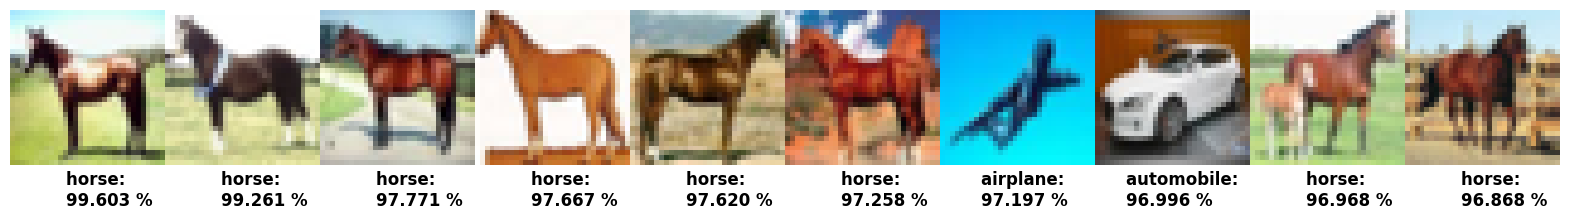

In [ ]:
show_the_best_predictions(model, X_test, y_test)

-------------------------------------------------------------------------------------------------------------------------------------


## Task Description:

You task of this exercise would be to improve the model's performance to achieve better results in image classification task. There is no need to change the preprocessing of the dataset. There are possible way how to improve the models performance:

1. Hyperparameter tunning - change the hyperparameters so that the model will perform better. You can experiment with the following:
 - *changing the number of neurons in the hidden layer*
 - *changing the number of hidden layers*
 - *changing the activation functions*
 - *changing the learning rate*
 - *changing the optimizer* - So far, we have used only Gradient descend as our optimizer, but Keras offers other algorithms that can perform better - check the documentation!
 - *changing the number of learning epochs*\
 - *changing the batch size*

2. Regularization techniques - There are several regularization techniques that can improve the model's performance:
 - *Dropout* -  In the Keras lib. you can add *dropout layer* into your Sequential model using the following command  *model.add(Dropout(p))* where *p* is an hyperparameter that controls dropout probabily, typical values are 0.1 - 0.5.
 - *L1, L2 regularization* - In keras the regularization is applied for selected layers, there is an example how to add l2 regularization to an layer (for more details check the documnetation):  *model.add(Dense(64, activation='relu', input_dim=100, kernel_regularizer=l2(0.01)))*
 - *Early stopping* -  In Keras, you can use the EarlyStopping callback to implement early stopping in your model. *early_stopping = EarlyStopping(monitor='val_loss', patience=3)*,  *model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])*


In [ ]:
# Load the cifar10 data and assign as Train and Test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Check the shape of X and Y values
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Scale the X to the range of (0,1)
X_train_scaled = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Adjust the Y to the categorical values
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)


X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Load the model Sequential
model = Sequential()

# First Flatten the input
model.add(Flatten(input_shape=(32, 32, 3)))

# First Hidden Layer
model.add(Dense(512, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.01))

# Second Hidden Layer
model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.01))

# Output Layer
model.add(Dense(10, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Use "adam" as the optimizer
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
# Train the model on the dataset
model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=32, validation_split = 0.2)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.2599 - loss: 2.1471 - val_accuracy: 0.3667 - val_loss: 1.8198
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.3720 - loss: 1.7820 - val_accuracy: 0.4020 - val_loss: 1.6985
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.4052 - loss: 1.6829 - val_accuracy: 0.4246 - val_loss: 1.6395
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 31ms/step - accuracy: 0.4252 - loss: 1.6266 - val_accuracy: 0.4205 - val_loss: 1.6424
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.4383 - loss: 1.5869 - val_accuracy: 0.4314 - val_loss: 1.6295
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.4539 - loss: 1.5640 - val_accuracy: 0.4250 - val_loss: 1.6304
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.4592 - loss: 1.5403 - val_accuracy: 0.4515 - val_loss: 1.5839
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.4604 -

So basically here I tried to create model, with the least amount of hidden layers and # of neurons. As I final model I used 2 hidden layers with 512 and 256 nodes. Also I used some regularization techniques and dropout in order to prevent overfitting (even if there is underfittin kinda)

In [ ]:
# Check the accuracy value on Test dataset
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4818 - loss: 1.5640
Test Accuracy: 48.61%


In [ ]:
predictions = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


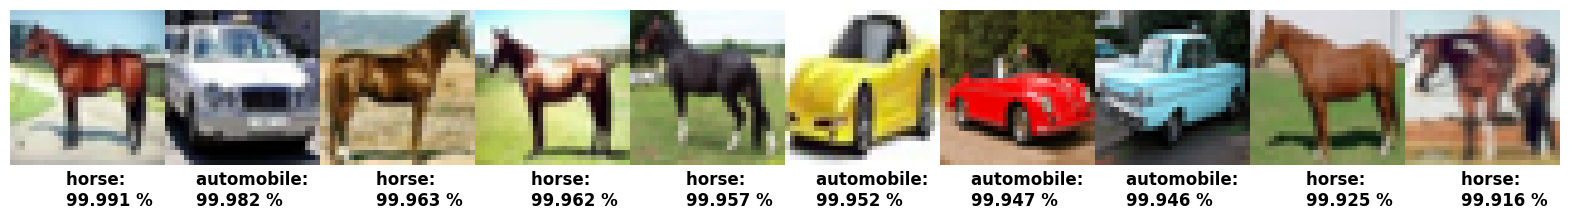

In [ ]:
show_the_best_predictions(model, X_test, y_test)


Try to make the highest testing accuracy possible. You can directly edit the code that is presented above, or you can copy everything into new cells. Please submit only the code with the best performance and briefly describe what approaches you have tried and what were the results

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


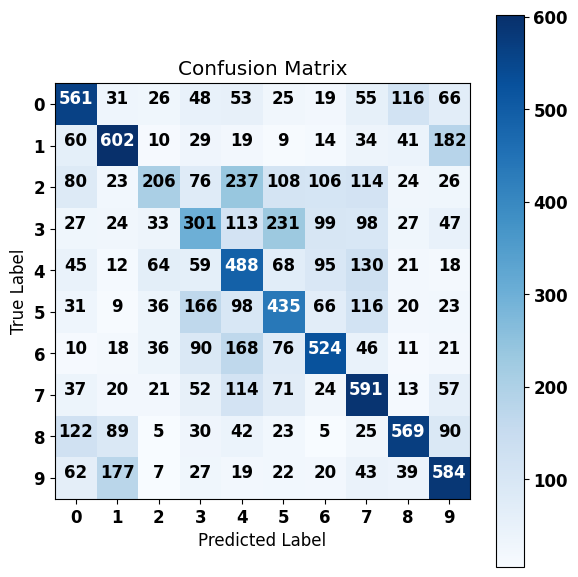

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Making predictions on our test/validation set
y_pred = model.predict(X_test)

# Converting predictions and true labels from one-hot to integer labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Computing the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')  # Use the 'Blues' colormap for better contrast
plt.title('Confusion Matrix')
plt.colorbar()

# Label the axes with class indices or class names if available
num_classes = cm.shape[0]
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add numeric labels to each cell of the matrix with better readability
thresh = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


In [ ]:
print(f"Labels: {labels}")

Labels: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [ ]:
# This part is to save model parameters, to use it after if needed
import pickle

# Save the model
filename = 'linear_model.sav'
pickle.dump(model, open(filename, 'wb'))

### WRITE YOUR DESCRIPTION IN THIS CELL ###

### Voluntary task:
Implement one of the hyperparameter tunning algorithms discussed in the lecture, such as *Grid Search*, *Random Search* or more sophisticated ones. Some of these algorithms are already included in the Keras. Check the documentation

In [ ]:
from sklearn.model_selection import GridSearchCV

### **Convolutional Neural Network (for fun)**

Here I just wanted to see the difference between CNN and perceptron based NN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, ReLU, MaxPool2D, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Model definition
model_c = Sequential()

# Convolutional Layer 1
model_c.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), padding='same', activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Layer 2
model_c.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_c.add(MaxPool2D(pool_size=(2, 2)))

# Flatten Layer (after Conv2D layers)
model_c.add(Flatten())

# Fully connected layers
model_c.add(Dense(128))
model_c.add(ReLU())
model_c.add(Dropout(0.1))

# Output layer
model_c.add(Dense(10, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_c.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model summary
model_c.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model with a validation split and early stopping
model_c.fit(X_train_scaled, y_train_encoded, epochs=100, batch_size=32, validation_split = 0.2, callbacks=[early_stopping])

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 80s 63ms/step - accuracy: 0.3944 - loss: 1.6773 - val_accuracy: 0.6029 - val_loss: 1.1384
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 75s 60ms/step - accuracy: 0.6030 - loss: 1.1162 - val_accuracy: 0.6505 - val_loss: 1.0049
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 87s 64ms/step - accuracy: 0.6679 - loss: 0.9327 - val_accuracy: 0.6768 - val_loss: 0.9240
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 76s 59ms/step - accuracy: 0.7093 - loss: 0.8228 - val_accuracy: 0.6729 - val_loss: 0.9421
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.7427 - loss: 0.7348 - val_accuracy: 0.6987 - val_loss: 0.8838
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 83s 59ms/step - accuracy: 0.7696 - loss: 0.6536 - val_accuracy: 0.7003 - val_loss: 0.8873
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.7974 - loss: 0.5665 - val_accuracy: 0.7064 - val_loss: 0.8903
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 74s 59ms/step - accuracy: 

In [ ]:
loss, accuracy = model_c.evaluate(X_test, y_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.6901 - loss: 0.8880
Test Accuracy: 69.17%


As expected Convolutional Layers improve the accuracy significantly, by using kernels to detect edges of objects.

In [ ]:
predictions = model_c.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step


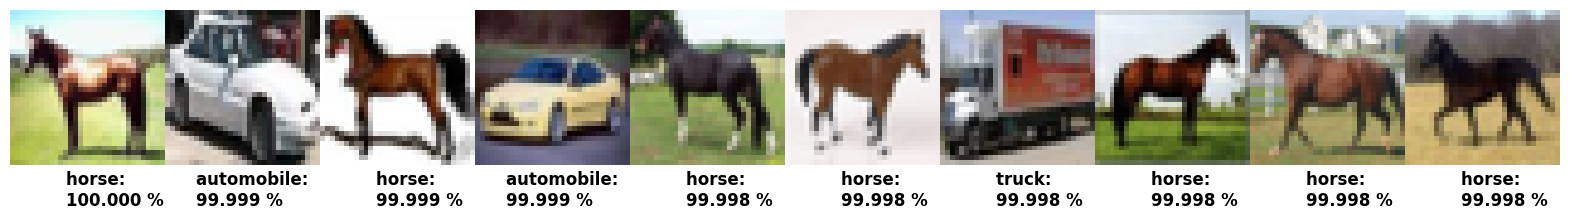

In [ ]:
show_the_best_predictions(model_c, X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


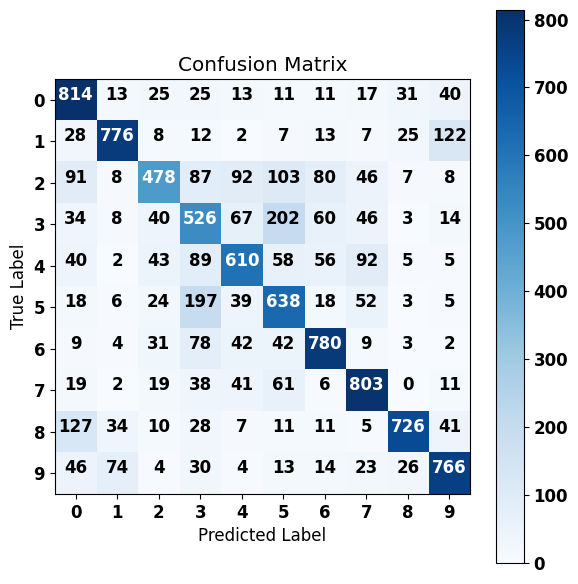

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Making predictions on our test/validation set
y_pred = model_c.predict(X_test)

# Converting predictions and true labels from one-hot to integer labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_encoded, axis=1)

# Computing the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')  # Use the 'Blues' colormap for better contrast
plt.title('Confusion Matrix')
plt.colorbar()

# Label the axes with class indices or class names if available
num_classes = cm.shape[0]
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add numeric labels to each cell of the matrix with better readability
thresh = cm.max() / 2.0
for i, j in itertools.product(range(num_classes), range(num_classes)):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
